# Декомпозиция галактик

Алгоритм. 

0) Необходим файл configN.imfit, который получается на раннем этапе (одномерная декомпозиция). N - какое-то число (2,3 и т.д.). Наверное, можно и самому его создать. Кроме того, необходимы файлы mask.fits (маскированные области, делается вручную через ds9 с конвертацией из ds9.reg в mask.fits при помощи скрипта regions2maskFits.py; в общем случае можно маскировать по-разному, поэтому в общем случае maskN.fits, где N - какое-то число), psf.fits (достаётся с Легаси), image.fits - "сырое" изображение.

1) Использование imfit.

imfit image.fits -c configN.imfit --loud --psf psf.fits --mask maskN.fits --ftol=1.0e-8 --save-params bestfitN.imfit --save-residual residualN.fits --mlr

(здесь N - какое-то число)
В результате создаются bestfitN.imfit (содержит параметры) и residualN.fits (остаточное изображение).

2) Использование makeimage.

makeimage bestfitN.imfit -o modelimageN.fits --refimage image.fits --psf psf.fits --output-functions comps_precN_

В результате создаются ...

makeimage bestfitN.imfit --refimage image.fits --save-fluxes fluxesN.dat

В результате создаётся файл fluxesN.dat с потоками компонент модели, в ноутбуке используется для вычисления отношений потоков.

3) Пропустить данный ноутбук. 
В результате создаются comps_precN*.fits (компоненты модели галактики) .

4) Перезаписать параметры из bestfitN.imfit в configN.imfit (чтобы ещё раз прогнать через imfit (т.е. начиная с пункта 1)) с помощью ноутбука parameters saver.ipynb.

5) Если всё устраивает, то на этом всё. Если модели подогнались не очень, то можно действовать так: 
а) перейти к пункту 1, поварьировав значения в configN.imfit и запустив imfit, дальше makeimage (первая половина пункта), пропускаем ноутбук, смотрим, если всё норм, то makeimage (вторая половина пункта) и ещё раз пропускаем ноутбук, чтобы отношения потоков правильные прописались, а если не всё норм, то перезаписываем параметры в config и делаем заново;
б) непосредственно работать с bestfitN.imfit (пункт 2), варьируя параметры, а дальше так же, как и в а). 

Здесь надо понять, что вычисление потоков через makeimage забирает немало времени, поэтому, чтоб вся работа шла быстрее, вычисление потоков оставляем на конец. 
В 5-ом пункте я бы предпочёл бы подпункт б), всё-таки imfit тоже время отбирает.


## imfit functions:

(используются в bestfitN.imfit)

FUNCTION DoubleBrokenExponential
PA
ell
I_0
h1
h2
h3
r_break1
r_break2

FUNCTION BrokenExponential2D
PA
I_0
h1
h2
r_break
alpha
h_z

FUNCTION BrokenExponential2
PA
ell
I_0
h1
h2
r_break

FUNCTION BrokenExponential
PA
ell
I_0
h1
h2
r_break
alpha

## parameters recalculation:

$$h_z = 2\times z_0$$

$$I_0 = J_0 \times 2 \times h_1 \times 0.262$$

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x7f4cf409f9c0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.ndimage import rotate
from astropy.io import fits as pyfits

from astropy.visualization import ZScaleInterval
import imfittools.make_slice as ms
import imfittools.ImfitModel as imfitmod

In [3]:
 # Функция для того, чтобы сделать срез вдоль х-структуры
def slice_rotate(img, fig, i, x1, x2, y1, y2):
    angle = np.arctan2(y2 - y1, x2 - x1)
    resid = rotate(img, angle=np.degrees(angle), reshape=False)
    
    ycen = img.shape[0] / 2
    xcen = img.shape[1] / 2
    
    x1r, y1r = rotate_coords(x1, y1, xcen, ycen, -angle)
    x2r, y2r = rotate_coords(x2, y2, xcen, ycen, -angle)
    
    x1r = int(x1r)
    x2r = int(x2r)
    y1r = int(y1r)
    y2r = int(y2r)
    
    plt.subplot(2, 2, i)
    plt.plot([x1, x2], [y1, y2])

    plt.subplot(2, 2, i+2)
    x_slice = resid[y1r, x1r:x2r]
    plt.plot(x_slice, '.', label='Image')
    
 # Вспомогательная функция для slice_rotate()
def rotate_coords(x1, y1, xcen, ycen, angle):
    xrot = (x1 - xcen) * np.cos(angle) - (y1 - ycen) * np.sin(angle) + xcen
    yrot = (x1 - xcen) * np.sin(angle) + (y1 - ycen) * np.cos(angle) + ycen
    return xrot, yrot

# Получаем индекс галактики в voting_with_coords.csv, чтобы по индексу можно было получить ra,dec
def getind_gal(name_gal,df):
    for i in arange(1,df.shape[0]):
        if name_gal == df[0][i]:
            return i 
            break

In [8]:
file_all_gal = 'voting_with_coords.csv'
df_all_gal = pd.read_csv('../data/{}'.format(file_all_gal), header=None)

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
mass_bulge
1354_49_0_line6745
 
Simbad:
http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=126.34665787d1.9872509496d&CooFrame=ICRS&CooEpoch=2000&CooEqui=2000&Radius=0.5&Radius.unit=arcmin&submit=submit+query&CoordList=
NED:
https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=126.34665787d%20%2B1.9872509496d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center
Legacy:
https://www.legacysurvey.org/viewer/?ra=126.34665787&dec=1.9872509496&layer=ls-dr9&zoom=13


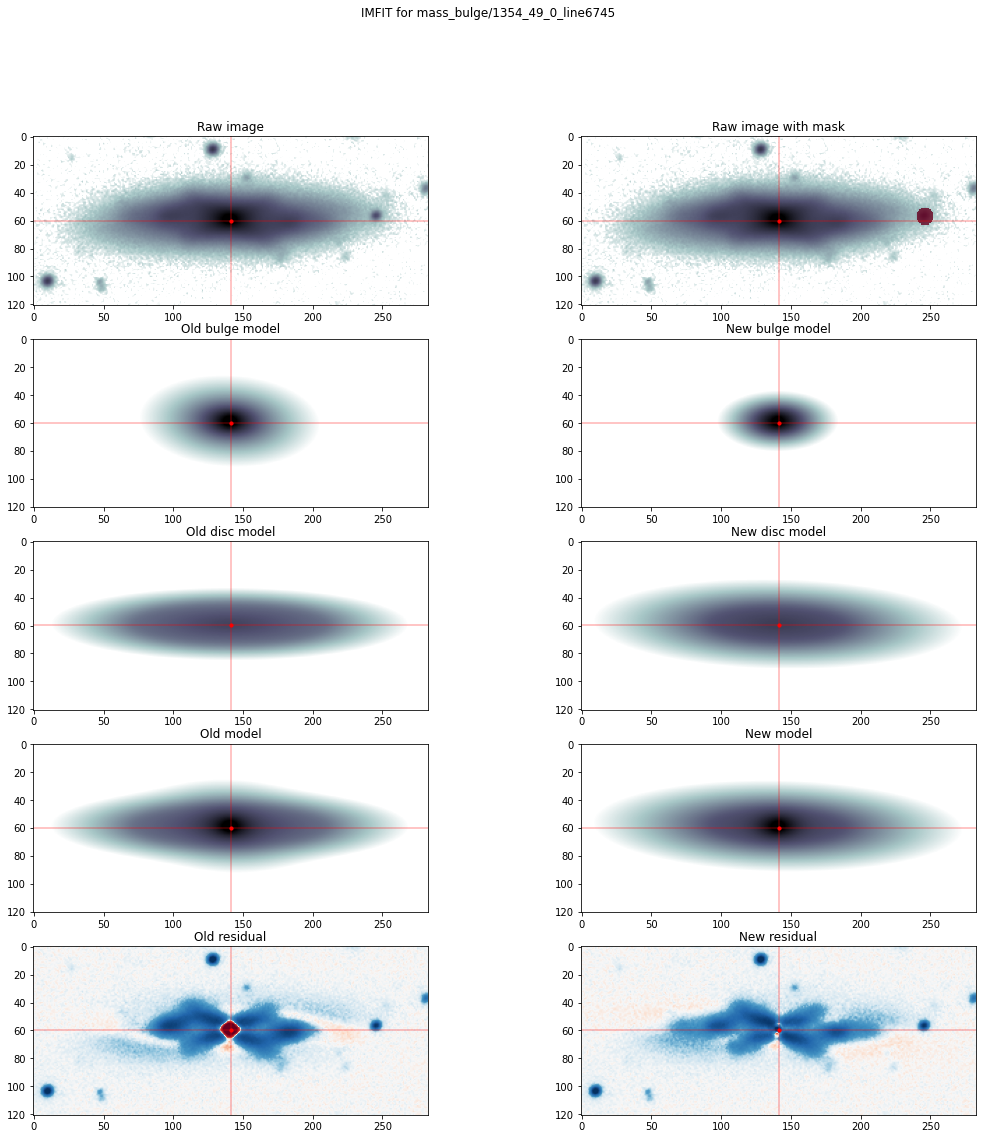

                                    ------------------------------
                                                  New
Reading '../data/small_samp/mass_bulge/1354_49_0_line6745/bestfit3.imfit':
  3 functions found (24 parameters)

Biggest component of a model is BknExp3D.1
It's coordinates 141.5,60.0.
It's position angle 91.2254
Making model


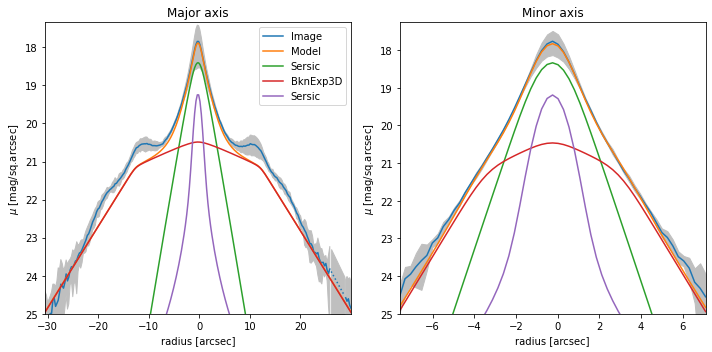

                                    ------------------------------
                                                  Old
Reading '../data/small_samp/mass_bulge/1354_49_0_line6745/bestfit2.imfit':
  2 functions found (17 parameters)

Biggest component of a model is BknExp3D.1
It's coordinates 141.5,60.0.
It's position angle 90.1681
Making model


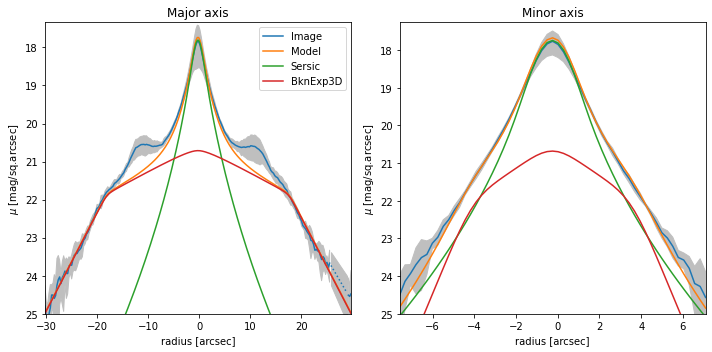

           ----------------------------------------------------------------------
           Old                                               New
                                         Bestfit:
#   Best-fit value: 156.338142                      #   Best-fit value: 526686.221991
#   Reduced value: 0.004587                         #   Reduced value: 15.452594
#   AIC: 180.347295                                 #   AIC: 526714.234314
#   BIC: 281.582070                                 #   BIC: 526832.339907
                                                    
X0		141.5000 # +/- 0.0000                           X0		141.5000 # +/- 0.0000
Y0		59.9500 # +/- 0.0000                            Y0		59.9500 # +/- 0.0000
FUNCTION Sersic                                     FUNCTION Sersic
PA		93.1502 # +/- 0                                 PA		     90 # +/- 0
ell		    0.5 # +/- 0                                ell		0.518284 # +/- 0.001133
n		1.98977 # +/- 0.44352                            n		  

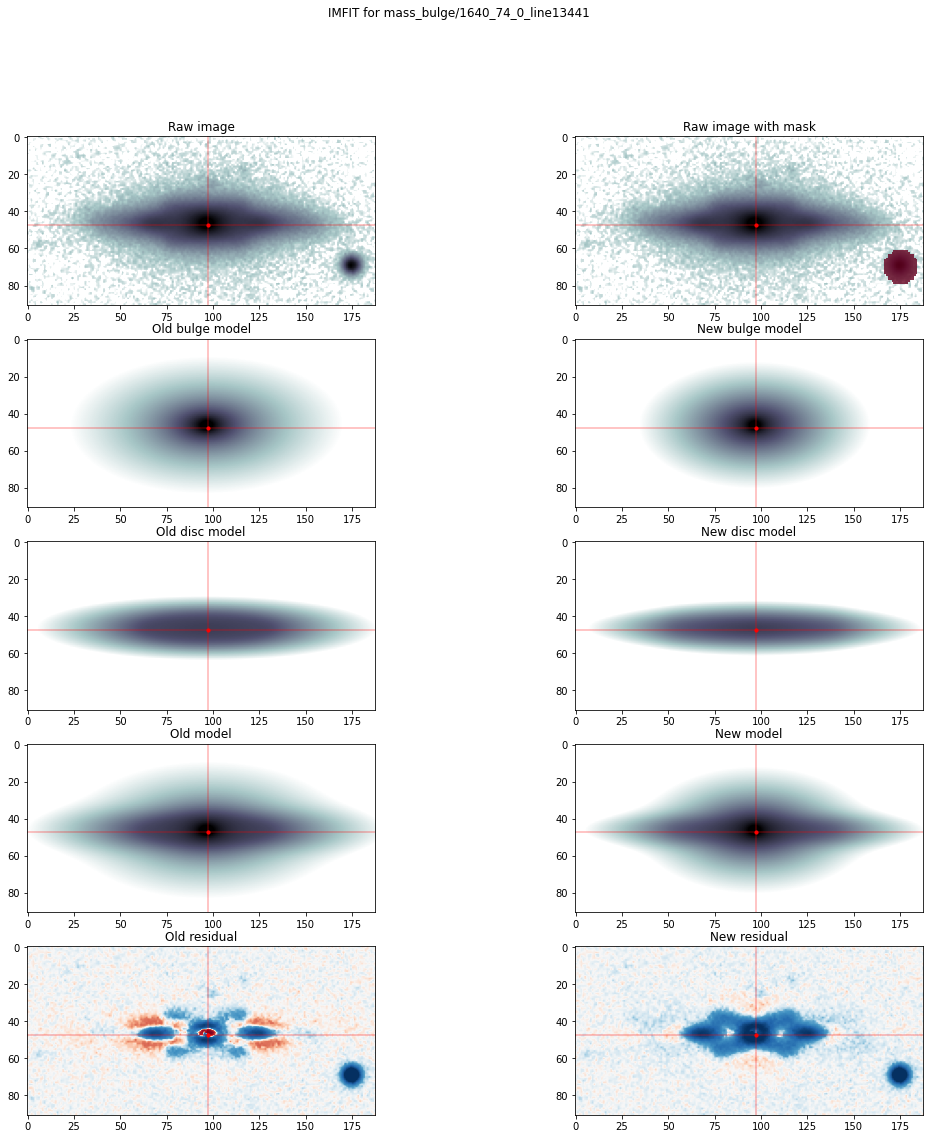

                                    ------------------------------
                                                  New
Reading '../data/small_samp/mass_bulge/1640_74_0_line13441/bestfit3.imfit':
  3 functions found (24 parameters)

Biggest component of a model is BknExp3D.1
It's coordinates 97.3,47.4.
It's position angle 90.1161
Making model


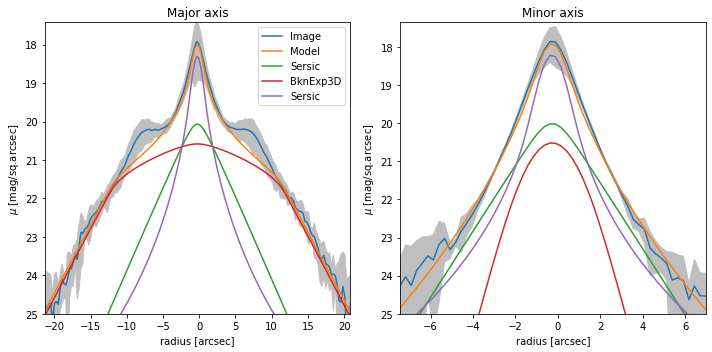

                                    ------------------------------
                                                  Old
Reading '../data/small_samp/mass_bulge/1640_74_0_line13441/bestfit2.imfit':
  2 functions found (17 parameters)

Biggest component of a model is BknExp3D.1
It's coordinates 97.3,47.4.
It's position angle 90.1132
Making model


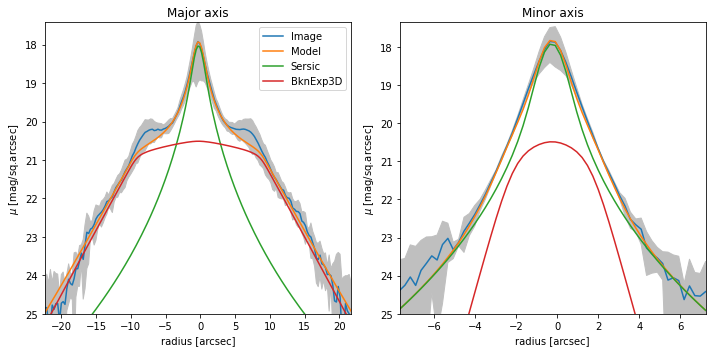

           ----------------------------------------------------------------------
           Old                                               New
                                         Bestfit:
#   Best-fit value: -5.194584                       #   Best-fit value: 4.998431
#   Reduced value: -0.000309                        #   Reduced value: 0.000298
#   AIC: 18.823999                                  #   AIC: 35.027024
#   BIC: 111.557169                                 #   BIC: 150.938121
                                                    
X0		97.3000 # +/- 0.0000                            X0		97.3000 # +/- 0.0000
Y0		47.4000 # +/- 0.0000                            Y0		47.4000 # +/- 0.0000
FUNCTION Sersic                                     FUNCTION Sersic
PA		89.4458 # +/- 2.996                             PA		89.7689 # +/- 1.6683
ell		0.499178 # +/- 0.051787                        ell		0.5 # +/- 0.045176
n		 2.9098 # +/- 0.616                              n		      1 # +/- 0


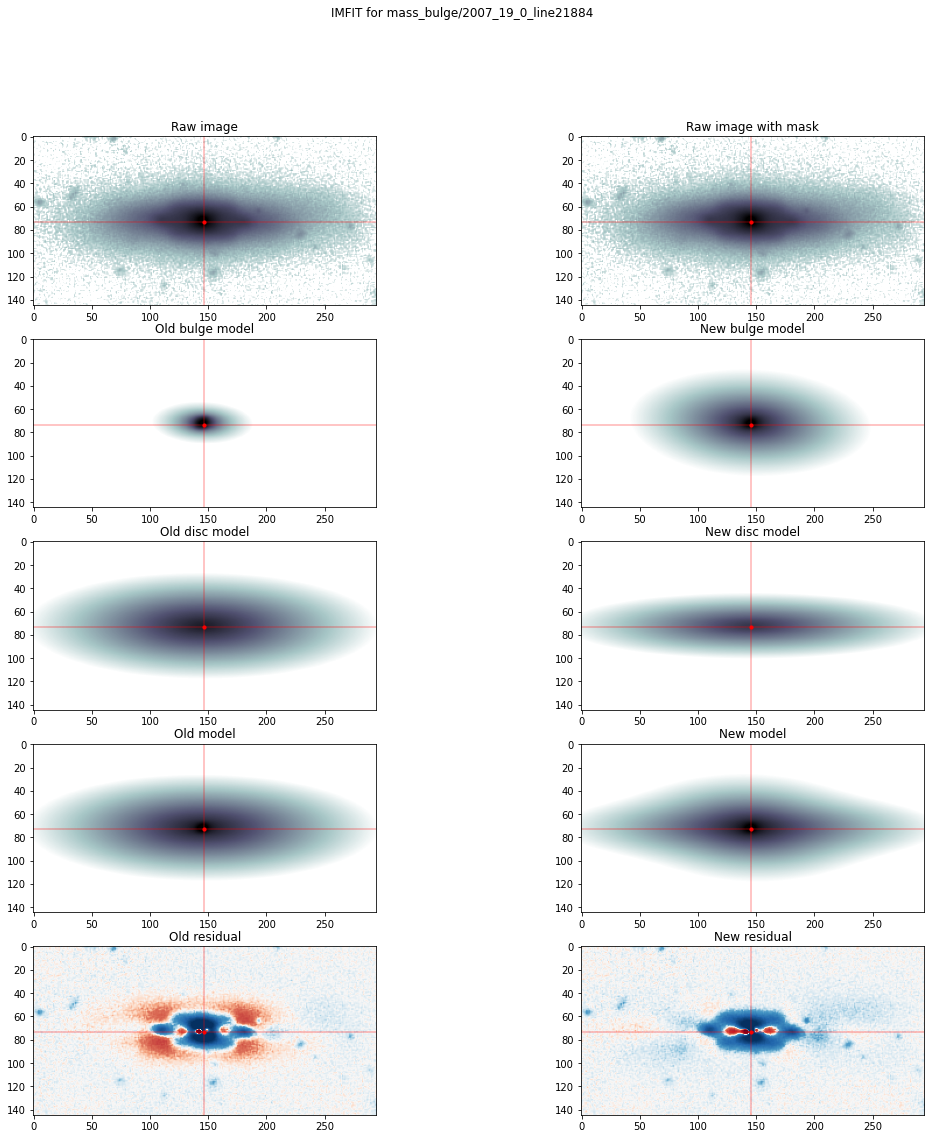

                                    ------------------------------
                                                  New
Reading '../data/small_samp/mass_bulge/2007_19_0_line21884/bestfit3.imfit':
  3 functions found (22 parameters)

Biggest component of a model is ExponentialDisk3D.1
It's coordinates 145.9,73.2.
It's position angle 90.0274
Making model


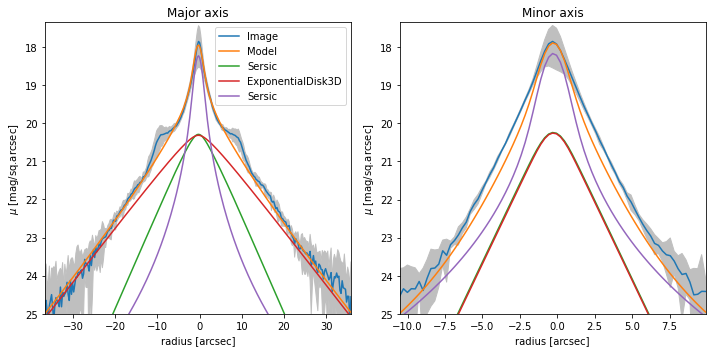

                                    ------------------------------
                                                  Old
Reading '../data/small_samp/mass_bulge/2007_19_0_line21884/bestfit2.imfit':
  2 functions found (15 parameters)

Biggest component of a model is ExponentialDisk3D.1
It's coordinates 145.9,73.2.
It's position angle 90.3061
Making model


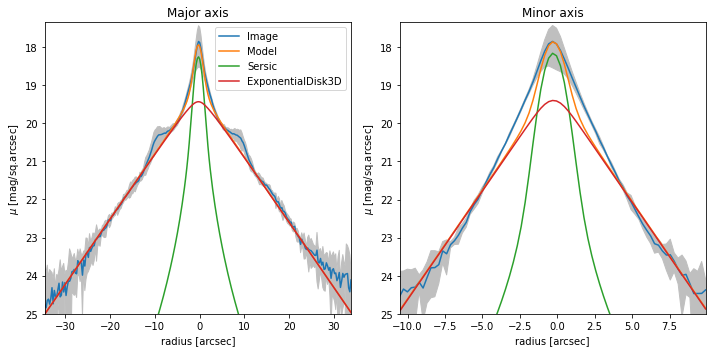

           ----------------------------------------------------------------------
           Old                                               New
                                         Bestfit:
#   Best-fit value: 132.227725                      #   Best-fit value: 37.347722
#   Reduced value: 0.003092                         #   Reduced value: 0.000873
#   AIC: 152.232870                                 #   AIC: 63.356235
#   BIC: 238.864816                                 #   BIC: 175.975940
                                                    
X0		145.9000 # +/- 0.0000                           X0		145.9000 # +/- 0.0000
Y0		73.2000 # +/- 0.0000                            Y0		73.2000 # +/- 0.0000
FUNCTION Sersic                                     FUNCTION Sersic
PA		91.9593 # +/- 1.1735                            PA		93.9593 # +/- 0
ell		    0.6 # +/- 0                                ell		    0.7 # +/- 0
n		4.20235 # +/- 0.13084                            n		      1 # +/- 0
I_e		2

In [9]:
dirs = ['hexagons', 'iso_break', 'mass_bulge']
num_in_dir = [3] #[2,3,1]
#dirs = ['mass_bulge']
#num_in_dir = [1]
#names = ['1237_50_0_line1676__EON_21.856_-1.913', 'EON_150.398_-2.994', '732_72_0_line4676', '1720_93_1_line10922', '2015_16_1_line2021', '804_63_1_line2514', '1354_49_0_line6745', '1640_74_0_line13441', '1937_45_0_line2281', '2007_19_0_line21884', 'EON_183.977_6.401']
#names = ['1237_50_0_line1676__EON_21.856_-1.913', 'EON_150.398_-2.994','732_72_0_line4676','1720_93_1_line10922','2015_16_1_line2021','804_63_1_line2514']

dirs = ['mass_bulge']
names = ['1354_49_0_line6745', '1640_74_0_line13441', '2007_19_0_line21884']

#names = ['804_63_1_line2514']
N_old = 2 # номер предыдущей модели (что было сделано в прошлый раз)
N_new = 3 # номер текущей модели 
     # Зачем это нужно? Чтобы следить, насколько хорошо/плохо идёт процесс (сравнивая прошлый результат с текущим)

i0 = 0
ii = 0
for index in range(len(dirs)):
    set_name = dirs[index]
    for indd in range(num_in_dir[i0]):
        i = names[ii]
        ii += 1
        print('=*'*50)
        print(set_name)
        print(i)
        
            # Дадим некоторые ссылки на галактику
        ind_gal = getind_gal(i,df_all_gal)
        ra = float(df_all_gal[1][ind_gal])
        dec = float(df_all_gal[2][ind_gal])
        url_simbad = "http://simbad.u-strasbg.fr/simbad/sim-coo?Coord={}d{}d&CooFrame=ICRS&CooEpoch=2000&CooEqui=2000&Radius=0.5&Radius.unit=arcmin&submit=submit+query&CoordList=".format(ra,dec)
        ra_ned = round(ra, 10)
        dec_ned = round(dec, 10)
        if dec>0.0:
            url_ned = "https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates={}d%20%2B{}d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center".format(ra_ned,dec_ned)
        else:
            url_ned = "https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates={}d%20{}d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center".format(ra_ned,dec_ned)

        url_legacy = "https://www.legacysurvey.org/viewer/?ra={}&dec={}&layer=ls-dr9&zoom=13".format(ra,dec)
        print(" ")
        print("Simbad:")
        print(url_simbad)
        print("NED:")
        print(url_ned)
        print("Legacy:")
        print(url_legacy)
            
            # Разберёмся со всеми путями -------------------
        path_config_old = '../data/small_samp/{}/{}/config{}.imfit'.format(set_name, i, N_old)
        path_config_new = '../data/small_samp/{}/{}/config{}.imfit'.format(set_name, i, N_new)
        path_imfit_old = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(set_name, i, N_old)
        path_imfit_new = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(set_name, i, N_new)
        path_flux_old = '../data/small_samp/{}/{}/fluxes{}.dat'.format(set_name, i, N_old)
        path_flux_new = '../data/small_samp/{}/{}/fluxes{}.dat'.format(set_name, i, N_new)
        path_psf = '../data/small_samp/{}/{}/psf.fits'.format(set_name, i)
        path_mask_old = '../data/small_samp/{}/{}/mask{}.fits'.format(set_name, i, N_old)
        path_mask_new = '../data/small_samp/{}/{}/mask{}.fits'.format(set_name, i, N_new)
        path_raw = '../data/small_samp/{}/{}/image.fits'.format(set_name, i)
        #path_model_base = '../data/images/{}/{}/model_r_rotcrop.fits'.format(set_name, i)
        #path_resid_base = '../data/images/{}/{}/residual_r_rotcrop.fits'.format(set_name, i)
        path_model_old = '../data/small_samp/{}/{}/modelimage{}.fits'.format(set_name, i, N_old)
        path_resid_old = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_old)
        path_model_new = '../data/small_samp/{}/{}/modelimage{}.fits'.format(set_name, i, N_new)
        path_resid_new = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_new)       
        path_bulge_model_old = '../data/small_samp/{}/{}/comps_prec{}_Sersics.fits'.format(set_name, i, N_old)
        path_bulge_model_new = '../data/small_samp/{}/{}/comps_prec{}_Sersics.fits'.format(set_name, i, N_new)
        path_bulge_bps_model_old = '../data/small_samp/{}/{}/comps_prec{}_1_Sersic.fits'.format(set_name, i, N_old)
        path_bulge_bps_model_new = '../data/small_samp/{}/{}/comps_prec{}_1_Sersic.fits'.format(set_name, i, N_new)
        hdulist_bulge_bps_model_old  = pyfits.open(path_bulge_bps_model_old)
        data_bulge_bps_model_old = hdulist_bulge_bps_model_old[0].data
        hdulist_bulge_bps_model_new  = pyfits.open(path_bulge_bps_model_new)
        data_bulge_bps_model_new = hdulist_bulge_bps_model_new[0].data
        data_bulge_model_old = data_bulge_bps_model_old
        data_bulge_model_new = data_bulge_bps_model_new       
        names_loc = os.listdir('../data/small_samp/{}/{}'.format(set_name, i))
        for name in names_loc:
            if name.find('comps_prec{}_3_Sersic'.format(N_old)) != -1:
                path_bulge_cent_model_old =  '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_bulge_cent_model_old  = pyfits.open(path_bulge_cent_model_old)
                data_bulge_cent_model_old = hdulist_bulge_cent_model_old[0].data
                data_bulge_model_old = data_bulge_model_old + data_bulge_cent_model_old
                hdu = pyfits.PrimaryHDU(data=data_bulge_model_old) 
                hdu.writeto(path_bulge_model_old, overwrite=True)
            if name.find('comps_prec{}_3_Sersic'.format(N_new)) != -1:
                path_bulge_cent_model_new =  '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_bulge_cent_model_new  = pyfits.open(path_bulge_cent_model_new)
                data_bulge_cent_model_new = hdulist_bulge_cent_model_new[0].data
                data_bulge_model_new = data_bulge_model_new + data_bulge_cent_model_new
                hdu = pyfits.PrimaryHDU(data=data_bulge_model_new) 
                hdu.writeto(path_bulge_model_new, overwrite=True)
            if name.find('comps_prec{}_2_'.format(N_old)) != -1:
                path_disc_model_old = '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_disc_model_old  = pyfits.open(path_disc_model_old)
                data_disc_model_old = hdulist_disc_model_old[0].data
            if name.find('comps_prec{}_2_'.format(N_new)) != -1:
                path_disc_model_new = '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_disc_model_new  = pyfits.open(path_disc_model_new)
                data_disc_model_new = hdulist_disc_model_new[0].data
        path_pic = '../data/small_samp/{}/{}/picture.png'.format(set_name, i)
        path_slice_x = '../data/small_samp/{}/{}/slice_x.png'.format(set_name, i)
        path_slice_old = '../data/small_samp/{}/{}/slice{}.png'.format(set_name, i, N_old)
        path_slice_new = '../data/small_samp/{}/{}/slice{}.png'.format(set_name, i, N_new)
        
            # Считаем координаты центра из bestfit'а
        with open(path_imfit_old) as file:
            for line in file:
                if line.find('X0') != -1:
                    XCEN_old = float(line.split()[1])
                if line.find('Y0') != -1:
                    YCEN_old = float(line.split()[1])
        with open(path_imfit_new) as file:
            for line in file:
                if line.find('X0') != -1:
                    XCEN_new = float(line.split()[1])
                if line.find('Y0') != -1:
                    YCEN_new = float(line.split()[1])
            
            # Прочитаем соответствующие фитсы
        hdulist_raw  = pyfits.open(path_raw)
        data_raw = hdulist_raw[0].data

        hdulist_model_old  = pyfits.open(path_model_old)
        data_model_old = hdulist_model_old[0].data
    
        hdulist_resid_old  = pyfits.open(path_resid_old)
        data_resid_old = hdulist_resid_old[0].data

        hdulist_model_new  = pyfits.open(path_model_new)
        data_model_new = hdulist_model_new[0].data
            
        data_resid_new = data_raw - data_model_new
        hdu = pyfits.PrimaryHDU(data=data_resid_new) 
        hdu.writeto(path_resid_new, overwrite=True)

            # Начнём рисовать
        fig = plt.figure(figsize=[18,18])
        
        plt.subplot(5, 2, 1)                    
        plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('Raw image')
        
        hdulist_mask_new  = pyfits.open(path_mask_new)
        mask_new = hdulist_mask_new[0].data
        mask_new_to_show = np.zeros_like(mask_new)
        mask_new_to_show[mask_new == 0] *= np.nan
        plt.subplot(5, 2, 2)                    
        plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.imshow(mask_new_to_show, alpha=0.8, cmap=cm.RdBu) # Рисуется маска 
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('Raw image with mask')
        
        plt.subplot(5, 2, 3) 
        plt.imshow(data_bulge_model_old, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old bulge model')
        
        plt.subplot(5, 2, 4) 
        plt.imshow(data_bulge_model_new, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New bulge model')
        
        plt.subplot(5, 2, 5) 
        plt.imshow(data_disc_model_old, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old disc model')
        
        plt.subplot(5, 2, 6) 
        plt.imshow(data_disc_model_new, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New disc model')
        
        plt.subplot(5, 2, 7)  
        plt.imshow(data_model_old, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old model')

        plt.subplot(5, 2, 8)
        plt.imshow(data_model_new, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New model')
        
        plt.subplot(5, 2, 9) 
        plt.imshow(data_resid_old, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old residual')
        
        plt.subplot(5, 2, 10)
        plt.imshow(data_resid_new, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu) 
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New residual')

        plt.savefig(path_pic)#,dpi=400)
        
        plt.suptitle(f'IMFIT for {set_name}/{i}')
        
        plt.show()

           # Теперь сделаем горизонтальный и вертикальный срезы, нарисуем
        magzpt = 22.5
        image_scale = 0.262
        
        print("%s %s" %(' '*35, '-'*30))
        print("%sNew" %(' '*50))
        ms.make_slice(path_raw, path_imfit_new, magzpt = magzpt, scale = image_scale, psf = path_psf, mask = path_mask_new, outname = path_slice_new)
        plt.show()
        print("%s %s" %(' '*35, '-'*30))
        print("%sOld" %(' '*50))
        ms.make_slice(path_raw, path_imfit_old, magzpt = magzpt, scale = image_scale, psf = path_psf, mask = path_mask_old, outname = path_slice_old)
        plt.show()
        
           # Рисунки нарисовали, теперь надо вывести параметры из файлов
        with open(path_imfit_old, 'r') as bfo:
            bfo_lines = bfo.readlines()[7:]
        with open(path_imfit_new, 'r') as bfn:
            bfn_lines = bfn.readlines()[7:]
        with open(path_config_old, 'r') as cfo:
            cfo_lines = cfo.readlines()
        with open(path_config_new, 'r') as cfn:
            cfn_lines = cfn.readlines()
        print("%s %s" %(' '*10, '-'*70))
        print("%s Old %s New" %(' '*10, ' '*45))
        print("%s Bestfit:" %(' '*40))
        mbf = []
        mbf.append(len(bfo_lines))
        mbf.append(len(bfn_lines))
        for l in range(max(mbf)):
            try:
                lengb = len(bfo_lines[l][:-1])
                print("%s %s %s" %(bfo_lines[l][:-1], ' '*(50-lengb), bfn_lines[l][:-1]))
            except:
                if mbf[0] == max(mbf):
                    print("%s" %(bfo_lines[l][:-1]))
                if mbf[1] == max(mbf):
                    print("%s %s" %(' '*50, bfn_lines[l][:-1]))
        print("%s Config:" %(' '*40))
        mcf = []
        mcf.append(len(cfo_lines))
        mcf.append(len(cfn_lines))
        for l in range(max(mcf)):
            try:
                lengc = len(cfo_lines[l][:-1])
                print("%s %s %s" %(cfo_lines[l][:-1], ' '*(50-lengc), cfn_lines[l][:-1]))
            except:
                if mcf[0] == max(mcf):
                    print("%s" %(cfo_lines[l][:-1]))
                if mcf[1] == max(mcf):
                    print("%s %s" %(' '*50, cfn_lines[l][:-1]))
                    
           # Параметры выведены. Теперь выведем отношение потоков компонентов моделей к суммарному потоку
         
           # Ноутбук будет дольше работать, проще в терминале запустить makeimage ... --save-fluxes, а потом 
           # из файла считать нужные отношения.
        #imf_class = imfitmod.ImfitModel(path_imfit_new)   # Т.е можно всё это организовать сразу в ноутбуке,
        #fluxes = imf_class.get_relative_fluxes()          # но тогда ноутбук будет дольше работать
        #print("Bulge(B/PS) / Total = %s" %(fluxes[0]))
        #print("Disk / Total = %s" %(fluxes[1]))
        #print("Bulge(central) / Total = %s" %(fluxes[2]))
    
        print("%s %s" %(' '*10, '-'*70))
        print("%s Old %s New" %(' '*15, ' '*45))
        print("%s Relative fluxes:" %(' '*30))
        sers1_old = 0
        with open(path_flux_old) as file:
            for l in file:
                if sers1_old == 0:
                    if l.find('Sersic') != -1:
                        bps_total_old = float(l.split()[3])
                        sers1_old = 1
                        continue
                    continue
                if sers1_old == 1:
                    disk_total_old = float(l.split()[3])
                    sers1_old = 2
                    continue
                if sers1_old == 2:
                    if l.find('Sersic') != -1:
                        cent_total_old = float(l.split()[3])
                        sers1_old = 3
                    break
        sers1_new = 0
        with open(path_flux_new) as file:
                for l in file:
                    if sers1_new == 0:
                        if l.find('Sersic') != -1:
                            bps_total_new = float(l.split()[3])
                            sers1_new = 1
                            continue
                        continue
                    if sers1_new == 1:
                        disk_total_new = float(l.split()[3])
                        sers1_new = 2
                        continue
                    if sers1_new == 2:
                        if l.find('Sersic') != -1:
                            cent_total_new = float(l.split()[3])
                            sers1_new = 3
                        break
        print("Bulge(B/PS) / Total = %s %s Bulge(B/PS) / Total = %s" %(bps_total_old, ' '*(17-len(str(bps_total_old))), bps_total_new))
        print("Disk / Total = %s %s Disk / Total = %s" %(disk_total_old, ' '*(24-len(str(disk_total_old))), disk_total_new))
        if sers1_old > sers1_new:
            print("Bulge(central) / Total = %s" %(cent_total_old))
        if sers1_old < sers1_new:
            print("%s Bulge(central) / Total = %s" %(' '*40, cent_total_new))
        if sers1_old == 3 and sers1_new == 3:
            print("Bulge(central) / Total = %s %s Bulge(central) / Total = %s" %(cent_total_old, ' '*(14-len(str(cent_total_old))), cent_total_new))              
    i0 += 1
                

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
hexagons
1237_50_0_line1676__EON_21.856_-1.913


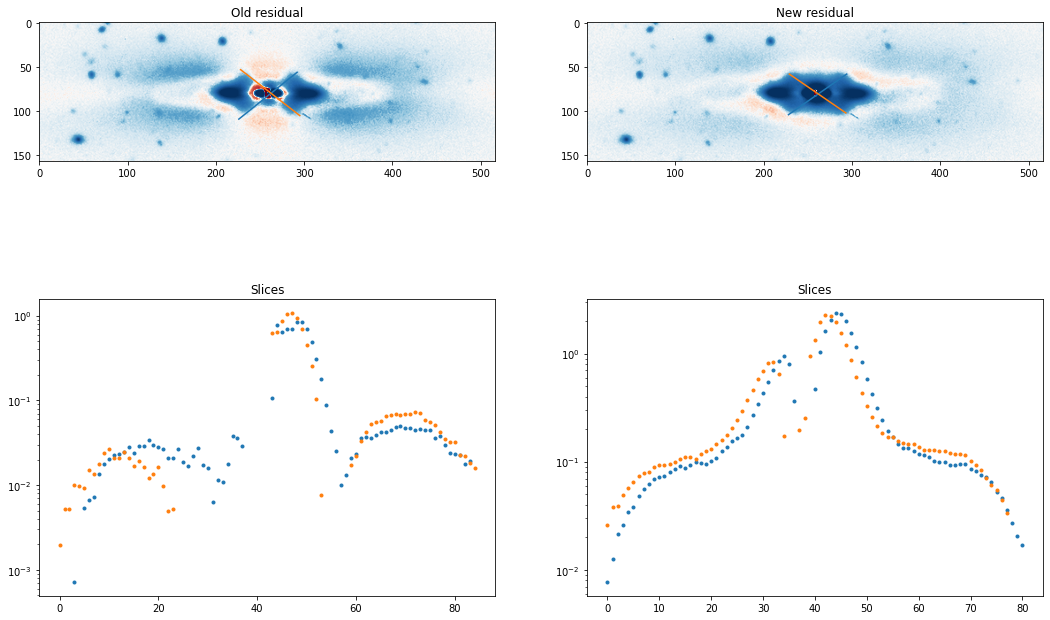

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
hexagons
EON_150.398_-2.994


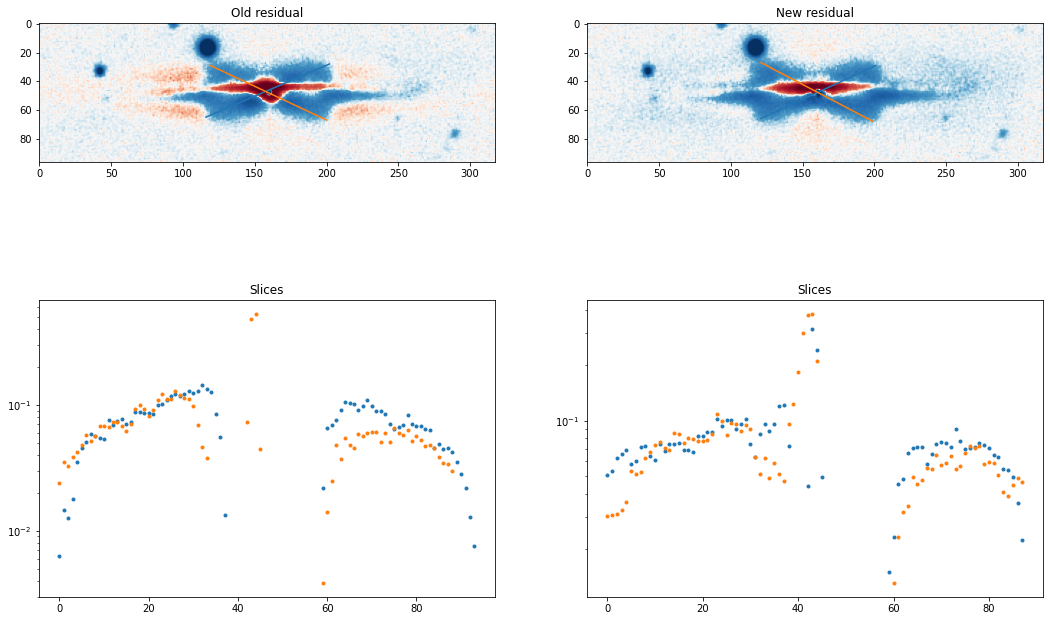

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iso_break
732_72_0_line4676


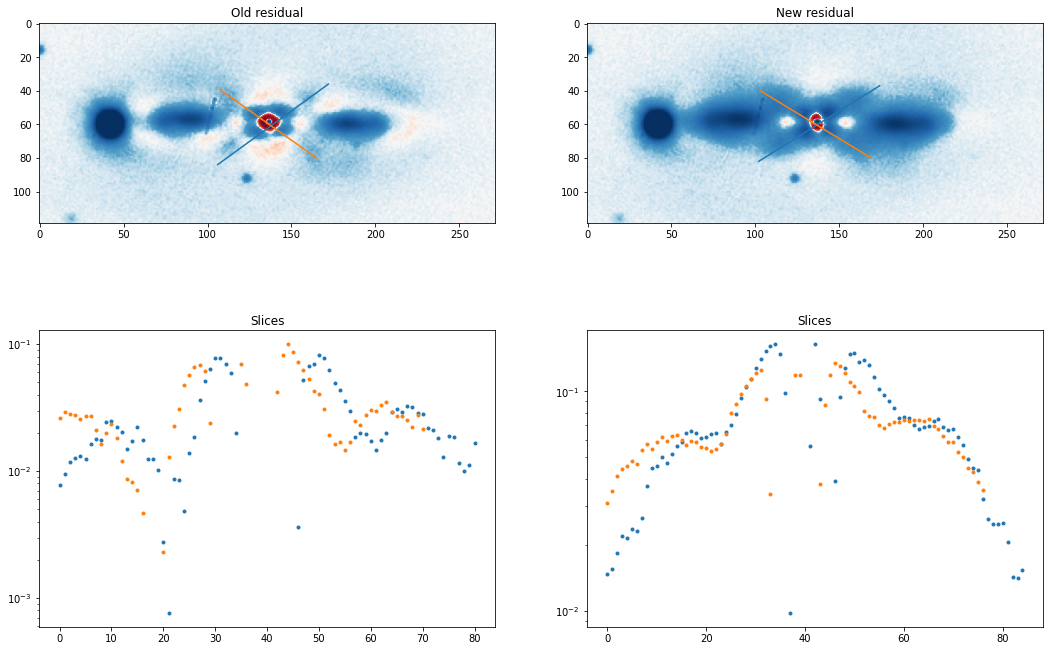

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iso_break
1720_93_1_line10922


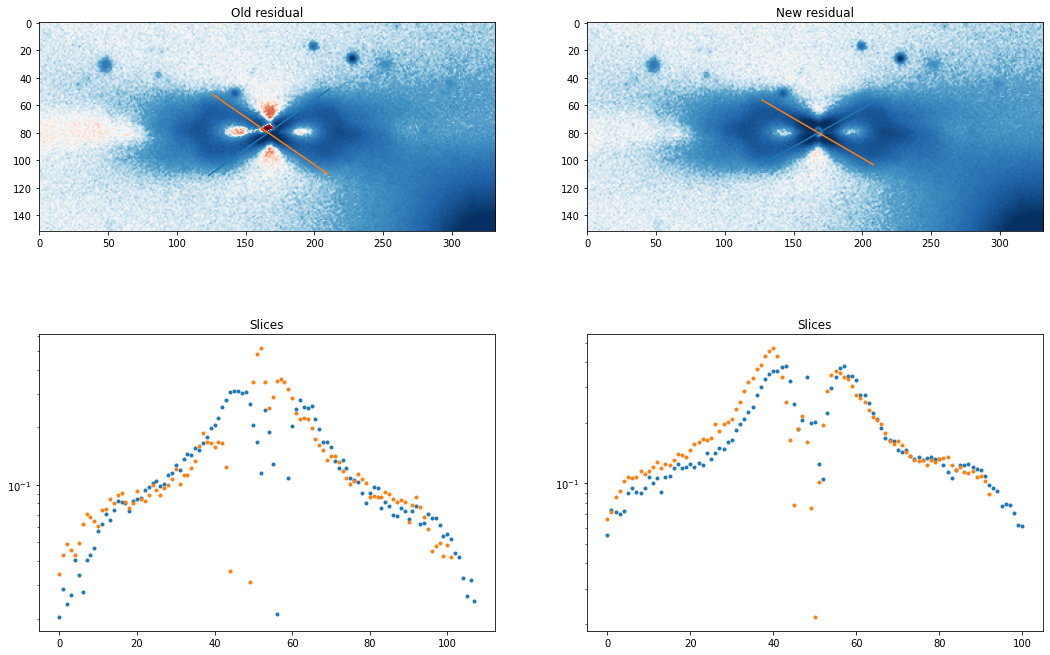

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iso_break
2015_16_1_line2021


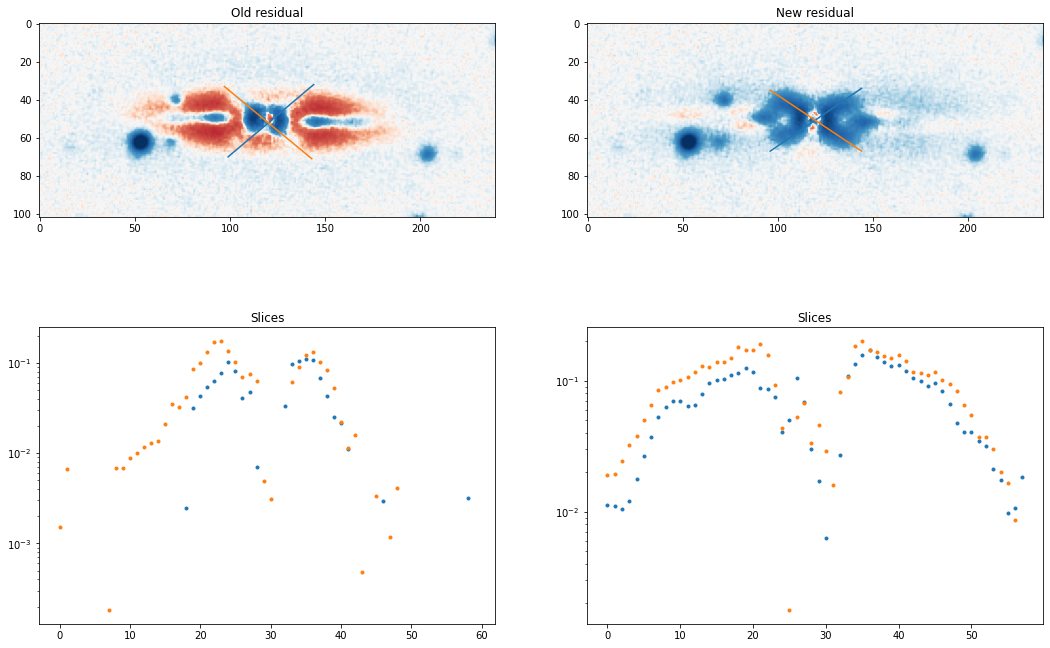

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
mass_bulge
804_63_1_line2514


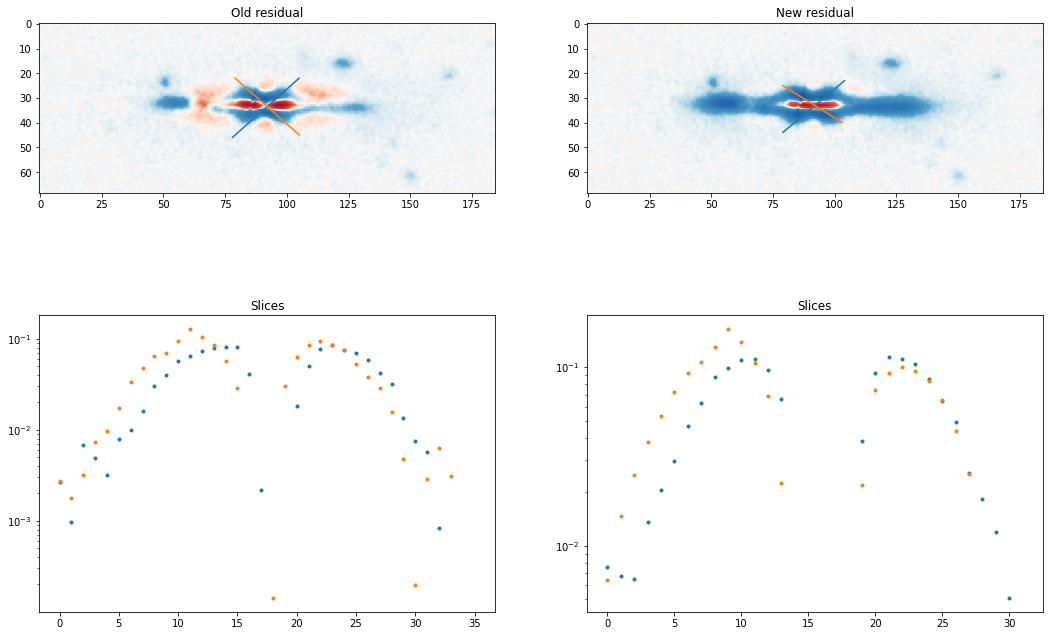

In [301]:
 # Решил срезы вдоль х-лучей вывести в отдельной ячейке

dirs = ['hexagons', 'iso_break', 'mass_bulge']
num_in_dir = [2,3,1]
#dirs = ['mass_bulge']
#num_in_dir = [1]
#names = ['1237_50_0_line1676__EON_21.856_-1.913', 'EON_150.398_-2.994', '732_72_0_line4676', '1720_93_1_line10922', '2015_16_1_line2021', '804_63_1_line2514', '1354_49_0_line6745', '1640_74_0_line13441', '1937_45_0_line2281', '2007_19_0_line21884', 'EON_183.977_6.401']
names = ['1237_50_0_line1676__EON_21.856_-1.913', 'EON_150.398_-2.994','732_72_0_line4676','1720_93_1_line10922','2015_16_1_line2021','804_63_1_line2514']
#names = ['804_63_1_line2514']
slice1_x1_old = [226,116,106,123,99,78]
slice1_x2_old = [292,202,172,211,144,105]
slice1_y1_old = [109,65,84,111,70,46]
slice1_y2_old = [56,28,36,48,32,22]
slice2_x1_old = [228,200,165,126,97,79]
slice2_x2_old = [295,119,107,210,143,105]
slice2_y1_old = [53,67,80,52,33,22]
slice2_y2_old = [105,29,39,110,71,45]

slice1_x1_new = [228,121,102,125,96,79]
slice1_x2_new = [294,201,174,213,144,104]
slice1_y1_new = [104,66,82,104,67,44]
slice1_y2_new = [58,29,37,55,34,23]
slice2_x1_new = [229,199,169,127,96,79]
slice2_x2_new = [293,121,103,208,144,103]
slice2_y1_new = [58,68,80,56,35,25]
slice2_y2_new = [102,27,40,103,67,40]

N_old = 2
N_new = 3

i0 = 0
ii = 0
for index in range(len(dirs)):
    set_name = dirs[index]
    for indd in range(num_in_dir[i0]):
        i = names[ii]
        ii += 1
        print('=*'*50)
        print(set_name)
        print(i)
           
            # Пути
        path_resid_old = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_old)
        path_resid_new = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_new)
            
            # Открытие файлов
        hdulist_resid_old  = pyfits.open(path_resid_old)
        data_resid_old = hdulist_resid_old[0].data
        hdulist_resid_new  = pyfits.open(path_resid_new)
        data_resid_new = hdulist_resid_new[0].data
                
        fig = plt.figure(figsize=[18,12])
        
        plt.subplot(2, 2, 1)
        plt.imshow(data_resid_old, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.title('Old residual')    
        slice_rotate(data_resid_old, fig, 1, slice1_x1_old[ii-1], slice1_x2_old[ii-1], slice1_y1_old[ii-1], slice1_y2_old[ii-1])
        slice_rotate(data_resid_old, fig, 1, slice2_x1_old[ii-1], slice2_x2_old[ii-1], slice2_y1_old[ii-1], slice2_y2_old[ii-1])
        
        plt.subplot(2, 2, 3)
        plt.yscale('log')
        plt.title('Slices')  
        
        plt.subplot(2, 2, 2)
        plt.imshow(data_resid_new, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.title('New residual')    
        slice_rotate(data_resid_new, fig, 2, slice1_x1_new[ii-1], slice1_x2_new[ii-1], slice1_y1_new[ii-1], slice1_y2_new[ii-1])
        slice_rotate(data_resid_new, fig, 2, slice2_x1_new[ii-1], slice2_x2_new[ii-1], slice2_y1_new[ii-1], slice2_y2_new[ii-1])
    
        plt.subplot(2, 2, 4)
        plt.yscale('log')
        plt.title('Slices')  
        
        plt.savefig(path_slice_x)#,dpi=400)
        
        plt.show()
    i0 += 1